In [1]:
!ls

experiments.ipynb	 mixed_valid_outputs.npy  train_targets.npy
linear.py		 mixed_valid_targets.npy  Untitled1.ipynb
load_data.py		 __pycache__		  Untitled.ipynb
make_data.py		 test_logits.npy	  valid_logits.npy
mixed_test_outputs.npy	 test_outputs.npy	  valid_outputs.npy
mixed_test_targets.npy	 test_targets.npy	  valid_targets.npy
mixed_train_outputs.npy  train_logits.npy
mixed_train_targets.npy  train_outputs.npy


In [2]:
import collections

import numpy as np
import sklearn.linear_model as lm
import sklearn.metrics
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Data Prep

In [4]:
train_data = {
    "deepsea_outputs": np.load("mixed_train_outputs.npy"),
#     "deepsea_logits": np.load("mixed_train_logits.npy"),
    "y": np.load("mixed_train_targets.npy")
}

valid_data = {
    "deepsea_outputs": np.load("mixed_valid_outputs.npy"),
#     "deepsea_logits": np.load("mixed_valid_logits.npy"),
    "y": np.load("mixed_valid_targets.npy")
}

test_data = {
    "deepsea_outputs": np.load("mixed_test_outputs.npy"),
#     "deepsea_logits": np.load("mixed_test_logits.npy"),
    "y": np.load("mixed_test_targets.npy")
}

# The validation set isn't big enough, so we take some from the training data.

# valid_data = {
#     "deepsea_outputs": np.concatenate([train_data["deepsea_outputs"][2200000:2400000],train_data["deepsea_outputs"][4200000:4400000],valid_data["deepsea_outputs"]], axis=0),
#     "deepsea_logits": np.concatenate([train_data["deepsea_logits"][2200000:2400000],train_data["deepsea_logits"][4200000:4400000],valid_data["deepsea_logits"]], axis=0),
#     "y": np.concatenate([train_data["y"][2200000:2400000],train_data["y"][4200000:4400000],valid_data["y"]], axis=0),
# }

# train_data = {
#     "deepsea_outputs": np.concatenate([train_data["deepsea_outputs"][0:2200000],train_data["deepsea_outputs"][2400000:4200000]], axis=0),
#     "deepsea_logits": np.concatenate([train_data["deepsea_logits"][0:2200000],train_data["deepsea_logits"][2400000:4200000]], axis=0),
#     "y": np.concatenate([train_data["y"][0:2200000],train_data["y"][2400000:4200000]], axis=0),
# } 

In [6]:
def auc(data, i):
    preds = data["deepsea_outputs"][:,i]
    labels = data["y"][:,i]
    return sklearn.metrics.roc_auc_score(labels, preds), sklearn.metrics.average_precision_score(labels, preds)

for i in range(19):
    print(auc(test_data, i))

(0.8576999749578289, 0.3700919542349726)
(0.949170615226667, 0.23610223599386693)
(0.9190826378212813, 0.20606869476955997)
(0.975220128673865, 0.3421692799670427)
(0.9682384003175021, 0.26922895046567935)
(0.9408194690857059, 0.21734958916440345)
(0.8829324011424516, 0.09433629608663682)
(0.8525510340702873, 0.10240875075834234)
(0.9357889649853666, 0.16207282134671605)
(0.9195035610423528, 0.257718006823373)
(0.9908787776505924, 0.37266025339094444)
(0.9380315134763743, 0.4277794118709136)
(0.743376195709318, 0.03619128545701074)
(0.9697098562189721, 0.5690863763254849)
(0.9475160166501252, 0.4793680352387042)
(0.9046498023337772, 0.3141778089793572)
(0.968621516482024, 0.28637023371384657)
(0.6814545708858999, 0.002103403845389069)
(0.7081355091960853, 0.0200487974038576)


In [4]:
def make_dataset(data,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 generator_fn):
    
    x_shape, gen = generator_fn(data)
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32,)*3,
        output_shapes=(data["y"].shape[1], x_shape, data["y"].shape[1],)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return dataset.make_one_shot_iterator()

# Generators output (DeepSea's probs, model inputs, ground truth)

def identity_gen(data):
    def g():
        for probs, logits, y in zip(data["deepsea_outputs"], data["deepsea_logits"], data["y"]):
            yield probs, logits, y
    return data["deepsea_logits"].shape[1], g

def random_mask(p, shape):
    return lambda: np.random.binomial(1, p, shape)

def dnase_mask():
    return np.array([1] + 18 * [0])

def position_mask(ids):
    out = np.zeros(19)
    out[ids] = 1
    return lambda: out

def imputation_gen(data, mask_fn=random_mask(.1, 19), x_shape=19*3):
    def g():
        for probs, logits, y in zip(data["deepsea_outputs"], data["deepsea_logits"], data["y"]):
            mask = mask_fn()
            x = y * mask + probs * (1 - mask)
            x = np.concatenate([logits, x, mask], axis=0)
            yield probs, x, y
    return x_shape, g
            
def paramaterized_imputation_gen(mask_fn, x_shape):
    return lambda data: imputation_gen(data, mask_fn, x_shape)



# Model definition

In [17]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 num_outputs,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 generator_fn=identity_gen,
                 masking=True):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)


            train_iter = make_dataset(train_data, batch_size, shuffle_size, prefetch_size, generator_fn)
            valid_iter = make_dataset(valid_data, batch_size, 1           , prefetch_size, generator_fn)
            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.deepsea_pred, self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = num_outputs
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size
            self.masking = masking

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
        
    def make_alt_dataset(self, data, batch_size, shuffle_size, prefetch_size, generator_fn):
        with self.graph.as_default():
            h = make_dataset(data, batch_size, shuffle_size, prefetch_size, generator_fn).string_handle()
            return self.sess.run(h)
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
        
    def train(self, num_steps, lr=None):
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, stop = self.test(8000, log=True, masking=self.masking)
                    if stop: break
                    tf.logging.info("")
                
    def test(self, num_samples, log=False, iterator_handle=None, masking=True):
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.deepsea_pred, self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else self.valid_handle})
                )
            deepsea = np.concatenate([v[0] for v in vals])
            preds = np.concatenate([v[1] for v in vals])
            truth = np.concatenate([v[3] for v in vals])
            if log and masking:
                mask = 1 - np.concatenate([v[2][:,19*2:] for v in vals]).reshape((-1))

                our_score = sklearn.metrics.roc_auc_score(truth.reshape((-1)), preds.reshape((-1)),   sample_weight=mask)
                deepsea_score = sklearn.metrics.roc_auc_score(truth.reshape((-1)), deepsea.reshape((-1)), sample_weight=mask)

                # Masked micro average
                tf.logging.info("Our AUC:     " + str(our_score))
                tf.logging.info("DeepSea AUC: " + str(deepsea_score))

#                 return deepsea, preds, truth, our_score > deepsea_score

            return deepsea, preds, truth, False


In [18]:
class Logistic(Model):
    def body_fn(self):
        return tf.layers.dense(self.x, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
    
class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
            
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

# Training

In [19]:
# try:
#     sess.close()
# except:
#     pass
# tf.reset_default_graph()
# sess = tf.InteractiveSession()

In [20]:
# logistic = Logistic(train_data, valid_data, 19, shuffle_size=1, generator_fn=imputation_fn)
# logistic.train(sess, 10000, lr=1e-4)
# imp8 = logistic.make_alt_dataset(sess, valid_data, 64, 1, 10, paramaterized_imputation_gen(random_mask(.8, 19), 3*19))
# dnase = logistic.make_alt_dataset(sess, valid_data, 64, 1, 10, paramaterized_imputation_gen(dnase_mask, 3*19))
# none = logistic.make_alt_dataset(sess, valid_data, 64, 1, 10, paramaterized_imputation_gen(random_mask(0, 19), 3*19))

# _ = logistic.test(sess, 40000, log=True)
# _ = logistic.test(sess, 40000, log=True, iterator_handle=imp8)
# _ = logistic.test(sess, 40000, log=True, iterator_handle=dnase)
# _ = logistic.test(sess, 40000, log=True, iterator_handle=none)

In [21]:
# mlp = MLP(2, 20, tf.tanh, train_data, valid_data, 19, shuffle_size=1, generator_fn=imputation_gen)
# mlp.train(sess, 20000, lr=1e-3)
# mlp.train(sess, 20000, lr=1e-4)
# mlp.train(sess, 20000, lr=1e-5)
# imp8 = mlp.make_alt_dataset(sess, valid_data, 64, 1, 10, paramaterized_imputation_gen(random_mask(.8, 19), 3*19))
# dnase = mlp.make_alt_dataset(sess, valid_data, 64, 1, 10, paramaterized_imputation_gen(dnase_mask, 3*19))
# _ = mlp.test(sess, 16000, log=True)
# for _ in range(3):
#     _ = mlp.test(sess, 16000, log=True, iterator_handle=imp8)

In [176]:
mlps = []
for i in range(3):
    mlp = MLP(4, 40, tf.tanh, train_data, valid_data, 19, shuffle_size=1, generator_fn=paramaterized_imputation_gen(position_mask([i]), 3*19), l1=.1)
    mlp.train(40000, lr=1e-3)
    mlp.train(40000, lr=1e-4)
    mlps.append(mlp)


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.20888677
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9558741311842852
INFO:tensorflow:DeepSea AUC: 0.9659993520392898
INFO:tensorflow:
INFO:tensorflow:2000 0.059482787
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9614680041206085
INFO:tensorflow:DeepSea AUC: 0.9696383207749399
INFO:tensorflow:
INFO:tensorflow:3000 0.9156255
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9636511078557051
INFO:tensorflow:DeepSea AUC: 0.9674656211640514
INFO:tensorflow:
INFO:tensorflow:4000 0.045395236
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.975934296714044
INFO:tensorflow:DeepSea AUC: 0.9804013362687495
INFO:tensorflow:
INFO:tensorflow:5000 0.27990714
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9498826961194554
INFO:tensorflow:DeepSea AUC: 0.9561572637079102
INFO:tensorflow:
INFO:tensorflow:6000 0.51744586
INFO:tensorflow:On v

INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9697024033159185
INFO:tensorflow:DeepSea AUC: 0.9679291568346481
INFO:tensorflow:
INFO:tensorflow:48000 0.41626716
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9638930998793457
INFO:tensorflow:DeepSea AUC: 0.9590077390831022
INFO:tensorflow:
INFO:tensorflow:49000 0.12392782
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9752847251593293
INFO:tensorflow:DeepSea AUC: 0.9732557994375245
INFO:tensorflow:
INFO:tensorflow:50000 0.1279182
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9656882083204829
INFO:tensorflow:DeepSea AUC: 0.9665495303991258
INFO:tensorflow:
INFO:tensorflow:51000 0.30879286
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9779793474795668
INFO:tensorflow:DeepSea AUC: 0.9745122914383743
INFO:tensorflow:
INFO:tensorflow:52000 0.042766742
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9635586120415094
INFO:tensorflow:DeepSea AUC: 0.96599935203

INFO:tensorflow:DeepSea AUC: 0.9726486304149087
INFO:tensorflow:
INFO:tensorflow:14000 0.4294009
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9731453538948536
INFO:tensorflow:DeepSea AUC: 0.9808232201141835
INFO:tensorflow:
INFO:tensorflow:15000 0.46543834
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9587872323831709
INFO:tensorflow:DeepSea AUC: 0.9665616645653838
INFO:tensorflow:
INFO:tensorflow:16000 0.5338144
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9630128744250217
INFO:tensorflow:DeepSea AUC: 0.9699870818443357
INFO:tensorflow:
INFO:tensorflow:17000 0.16525716
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9529128070099852
INFO:tensorflow:DeepSea AUC: 0.9613165574538866
INFO:tensorflow:
INFO:tensorflow:18000 0.18591267
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9622020020270832
INFO:tensorflow:DeepSea AUC: 0.9662227532929052
INFO:tensorflow:
INFO:tensorflow:19000 0.12378792
INFO:tensorflow:On valid

INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9744558244108212
INFO:tensorflow:DeepSea AUC: 0.9762803063750364
INFO:tensorflow:
INFO:tensorflow:61000 0.2912757
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9741268668560417
INFO:tensorflow:DeepSea AUC: 0.9756585739444428
INFO:tensorflow:
INFO:tensorflow:62000 2.1052065
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9652171673829931
INFO:tensorflow:DeepSea AUC: 0.9662792317611295
INFO:tensorflow:
INFO:tensorflow:63000 0.21726099
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9731328741724501
INFO:tensorflow:DeepSea AUC: 0.9745449448219826
INFO:tensorflow:
INFO:tensorflow:64000 0.17310889
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9711432193764229
INFO:tensorflow:DeepSea AUC: 0.9726486304149087
INFO:tensorflow:
INFO:tensorflow:65000 0.12520905
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9791411312590991
INFO:tensorflow:DeepSea AUC: 0.9808232201141

INFO:tensorflow:DeepSea AUC: 0.9394740142767602
INFO:tensorflow:
INFO:tensorflow:27000 0.19882973
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.961591561066084
INFO:tensorflow:DeepSea AUC: 0.9650395588587869
INFO:tensorflow:
INFO:tensorflow:28000 0.28345793
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.959980695957298
INFO:tensorflow:DeepSea AUC: 0.962656194323019
INFO:tensorflow:
INFO:tensorflow:29000 0.22762112
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9518643876342439
INFO:tensorflow:DeepSea AUC: 0.9593238834820405
INFO:tensorflow:
INFO:tensorflow:30000 0.12480806
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9527892742558828
INFO:tensorflow:DeepSea AUC: 0.9627197486081742
INFO:tensorflow:
INFO:tensorflow:31000 0.3490126
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9426419027898026
INFO:tensorflow:DeepSea AUC: 0.9576209867332061
INFO:tensorflow:
INFO:tensorflow:32000 2.1864326
INFO:tensorflow:On validati

INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9751017512112741
INFO:tensorflow:DeepSea AUC: 0.9761847756492747
INFO:tensorflow:
INFO:tensorflow:74000 0.16352694
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.956286719437689
INFO:tensorflow:DeepSea AUC: 0.9521285292148965
INFO:tensorflow:
INFO:tensorflow:75000 0.0862273
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9660968433227768
INFO:tensorflow:DeepSea AUC: 0.9673523867561991
INFO:tensorflow:
INFO:tensorflow:76000 0.05944837
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9663179205881064
INFO:tensorflow:DeepSea AUC: 0.9646937762275227
INFO:tensorflow:
INFO:tensorflow:77000 0.91588473
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9394294119167527
INFO:tensorflow:DeepSea AUC: 0.9394740142767602
INFO:tensorflow:
INFO:tensorflow:78000 0.041983247
INFO:tensorflow:On validation
INFO:tensorflow:Our AUC:     0.9682526010053617
INFO:tensorflow:DeepSea AUC: 0.965039558858

In [180]:
# P(TF1 && TF2)
eq_aucs = []
eq_prcs = []
# P(TF1 && !TF2)
j10_aucs = []
j10_prcs = []
# P(TF2|TF1)
aucs = []
prcs = []
# P(TF2|TF1=0)
cond0_aucs = []
cond0_prcs = []
# P(TF2|TF1=0)
cond1_aucs = []
cond1_prcs = []

twoway_preds = []

for i, mlp in enumerate(mlps):
    ds = mlp.make_alt_dataset(test_data, 64, 1, 10, paramaterized_imputation_gen(position_mask([i]), 3*19))
    deepsea, preds, truth, _ = mlp.test(30000, log=True, iterator_handle=ds)
    for j in range(19):
        if i == j: continue
        deepsea_pred = deepsea[:,i]*deepsea[:,j] #P(TFi|S)P(TFj|S)
        our_pred = deepsea[:,i]*preds[:,j] #P(TFi|S)P(TFj|TFi,S)
        truthij = truth[:,i]*truth[:,j] # TFi && TFj
        if np.any(truthij):
            eq_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred), sklearn.metrics.roc_auc_score(truthij, deepsea_pred)))
            eq_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred), sklearn.metrics.average_precision_score(truthij, deepsea_pred)))

        deepsea_pred = deepsea[:,i]*(1-deepsea[:,j]) #P(TFi|S)P(TFj|S)
        our_pred = deepsea[:,i]*(1-preds[:,j]) #P(TFi|S)P(TFj|TFi,S)
        truthij = truth[:,i]*(1-truth[:,j]) # TFi && TFj
        if np.any(truthij):
            j10_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred), sklearn.metrics.roc_auc_score(truthij, deepsea_pred)))
            j10_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred), sklearn.metrics.average_precision_score(truthij, deepsea_pred)))

        deepsea_pred = deepsea[:,j] #P(TFj|S)
        our_pred = preds[:,j] #P(TFj|TFi,S)
        truthij = truth[:,j] # TFj
        if np.any(truthij):
            aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred), sklearn.metrics.roc_auc_score(truthij, deepsea_pred)))
            prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred), sklearn.metrics.average_precision_score(truthij, deepsea_pred)))
            cond0_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred, sample_weight=1-truth[:,i]), sklearn.metrics.roc_auc_score(truthij, deepsea_pred, sample_weight=1-truth[:,i])))
            cond0_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred, sample_weight=1-truth[:,i]), sklearn.metrics.average_precision_score(truthij, deepsea_pred, sample_weight=1-truth[:,i])))
            cond1_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred, sample_weight=truth[:,i]), sklearn.metrics.roc_auc_score(truthij, deepsea_pred, sample_weight=truth[:,i])))
            cond1_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred, sample_weight=truth[:,i]), sklearn.metrics.average_precision_score(truthij, deepsea_pred, sample_weight=truth[:,i])))
    twoway_predsi = []
    for j in range(len(mlps)):
        if i == j:
            twoway_predsi.append([])
            continue
        our_pred = deepsea[:,i]*preds[:,j]
        deepsea_pred = deepsea[:,i]*deepsea[:,j]
        truthij = truth[:,i]*truth[:,j]
        if np.any(truthij):
            twoway_predsi.append((np.count_nonzero(truthij), our_pred, deepsea_pred, sklearn.metrics.roc_auc_score(truthij, our_pred), sklearn.metrics.roc_auc_score(truthij, deepsea_pred), (i,j)))
    twoway_preds.append(twoway_predsi)


INFO:tensorflow:Our AUC:     0.9602198199054667
INFO:tensorflow:DeepSea AUC: 0.9582300797273284


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:443: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


INFO:tensorflow:Our AUC:     0.953009997239823
INFO:tensorflow:DeepSea AUC: 0.9561404407591383


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


INFO:tensorflow:Our AUC:     0.9583024728579127
INFO:tensorflow:DeepSea AUC: 0.9590244014815782


In [197]:
# deepsea, preds, truth, _ = mlps[0].test(30000, log=True)
j = 1
# for j in range(18):
print(sklearn.metrics.average_precision_score(truth[:,j], preds[:,j]), sklearn.metrics.average_precision_score(truth[:,j], deepsea[:,j]))

0.0203181217050717 0.056604253720988804


47
209


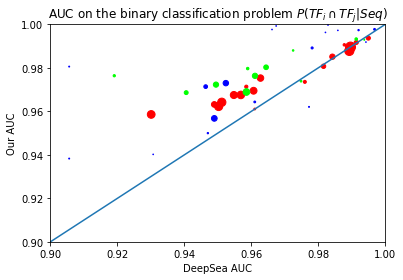

54
1264


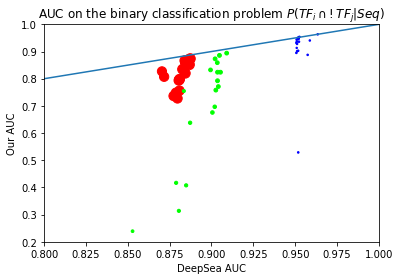

54
1271


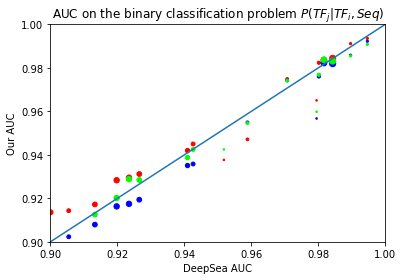

In [184]:
def plot(aucs, prcs=None, prob="", ranges=([.9,1],[.9,1])):
    cutoff = 0
    plt.scatter(x=[auc[2] for auc in aucs if auc[0] > cutoff],
                y=[auc[1] for auc in aucs if auc[0] > cutoff],
                s=100*np.array([auc[0] for auc in aucs if auc[0] > cutoff])/max([auc[0] for auc in aucs if auc[0] > cutoff]),
                c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
    plt.plot([0, 1], [0, 1])
    plt.title("AUC on the binary classification problem " + prob)
    plt.xlabel("DeepSea AUC")
    plt.ylabel("Our AUC")
    plt.xlim(ranges[0])
    plt.ylim(ranges[1])
    print(len([auc[2] for auc in aucs if auc[0] > cutoff]))
    print(max([auc[0] for auc in aucs if auc[0] > cutoff]))
    plt.show()
    if prcs:
        cutoff = 0
        plt.scatter(x=[prc[2] for prc in prcs if prc[0] > cutoff],
                    y=[prc[1] for prc in prcs if prc[0] > cutoff],
                    s=100*np.array([prc[1] for prc in prcs if prc[0] > cutoff])/max([prc[1] for prc in prcs if prc[0] > cutoff]),
                    c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
        plt.plot([0, 1], [0, 1])
        plt.title("AUPRC on the binary classification problem " + prob)
        plt.xlabel("DeepSea AUPRC")
        plt.ylabel("Our AUPRC")
        plt.show()
    
plot(eq_aucs, None, "$P(TF_i\cap TF_j | Seq)$")
plot(j10_aucs, None, "$P(TF_i\cap !TF_j | Seq)$", ([.8,1], [.2,1]))
plot(aucs, None, "$P(TF_j | TF_i, Seq)$")
# for i in range(3):
#     for j in range(i,3):
#         if i == j:
#             continue
# #         print(np.mean(abs(twoway_preds[i][j][1] - twoway_preds[j][i][1])))
#         assert np.all(twoway_preds[i][j][2] == twoway_preds[j][i][2])
#         print(i,j, twoway_preds[i][j][0])
#         print(np.mean(abs(twoway_preds[i][j][1] - twoway_preds[j][i][1])))
#         print(np.mean(abs(twoway_preds[i][j][1] - twoway_preds[i][j][2])))
#         print(np.mean(abs(twoway_preds[j][i][1] - twoway_preds[i][j][2])))
#     print()

54
1271


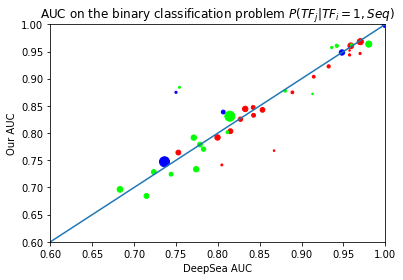

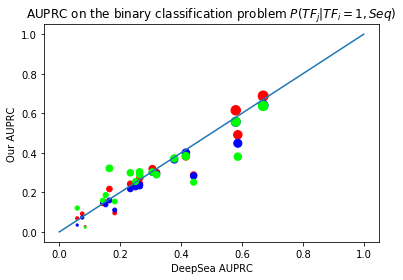

In [122]:
cutoff = 0
cond_aucs = cond1_aucs
plt.scatter(x=[auc[2] for auc in cond_aucs if auc[0] > cutoff],
            y=[auc[1] for auc in cond_aucs if auc[0] > cutoff],
            s=100*np.array([auc[0] for auc in cond_aucs if auc[0] > cutoff])/max([auc[0] for auc in cond_aucs if auc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUC on the binary classification problem $P(TF_j | TF_i=1, Seq)$")
plt.xlabel("DeepSea AUC")
plt.ylabel("Our AUC")
plt.xlim([0.6,1])
plt.ylim([0.6,1])
print(len([auc[2] for auc in cond_aucs if auc[0] > cutoff]))
print(max([auc[0] for auc in cond_aucs if auc[0] > cutoff]))
plt.show()
cutoff = 0
plt.scatter(x=[prc[2] for prc in cond_prcs if prc[0] > cutoff],
            y=[prc[1] for prc in cond_prcs if prc[0] > cutoff],
            s=100*np.array([prc[1] for prc in cond_prcs if prc[0] > cutoff])/max([prc[1] for prc in cond_prcs if prc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUPRC on the binary classification problem $P(TF_j | TF_i=1, Seq)$")
plt.xlabel("DeepSea AUPRC")
plt.ylabel("Our AUPRC");


54
1271


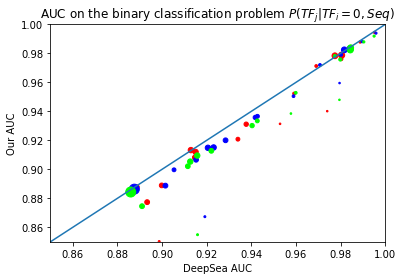

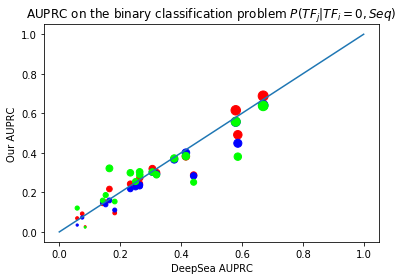

In [123]:
cutoff = 0
cond_aucs = cond0_aucs
plt.scatter(x=[auc[2] for auc in cond_aucs if auc[0] > cutoff],
            y=[auc[1] for auc in cond_aucs if auc[0] > cutoff],
            s=100*np.array([auc[0] for auc in cond_aucs if auc[0] > cutoff])/max([auc[0] for auc in cond_aucs if auc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUC on the binary classification problem $P(TF_j | TF_i=0, Seq)$")
plt.xlabel("DeepSea AUC")
plt.ylabel("Our AUC")
plt.xlim([0.85,1])
plt.ylim([0.85,1])
print(len([auc[2] for auc in cond_aucs if auc[0] > cutoff]))
print(max([auc[0] for auc in cond_aucs if auc[0] > cutoff]))
plt.show()
cutoff = 0
plt.scatter(x=[prc[2] for prc in cond_prcs if prc[0] > cutoff],
            y=[prc[1] for prc in cond_prcs if prc[0] > cutoff],
            s=100*np.array([prc[1] for prc in cond_prcs if prc[0] > cutoff])/max([prc[1] for prc in cond_prcs if prc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUPRC on the binary classification problem $P(TF_j | TF_i=0, Seq)$")
plt.xlabel("DeepSea AUPRC")
plt.ylabel("Our AUPRC");

54
1271


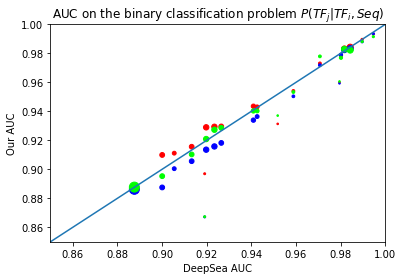

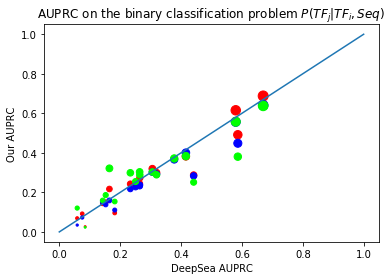

In [125]:
cutoff = 0
cond_aucs = cond01_aucs
plt.scatter(x=[auc[2] for auc in cond_aucs if auc[0] > cutoff],
            y=[auc[1] for auc in cond_aucs if auc[0] > cutoff],
            s=100*np.array([auc[0] for auc in cond_aucs if auc[0] > cutoff])/max([auc[0] for auc in cond_aucs if auc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUC on the binary classification problem $P(TF_j | TF_i, Seq)$")
plt.xlabel("DeepSea AUC")
plt.ylabel("Our AUC")
plt.xlim([0.85,1])
plt.ylim([0.85,1])
print(len([auc[2] for auc in cond_aucs if auc[0] > cutoff]))
print(max([auc[0] for auc in cond_aucs if auc[0] > cutoff]))
plt.show()
cutoff = 0
plt.scatter(x=[prc[2] for prc in cond_prcs if prc[0] > cutoff],
            y=[prc[1] for prc in cond_prcs if prc[0] > cutoff],
            s=100*np.array([prc[1] for prc in cond_prcs if prc[0] > cutoff])/max([prc[1] for prc in cond_prcs if prc[0] > cutoff]),
            c=np.array([[1,0,0]]*18+[[0,0,1]]*18+[[0,1,0]]*18))
plt.plot([0, 1], [0, 1])
plt.title("AUPRC on the binary classification problem $P(TF_j | TF_i0, Seq)$")
plt.xlabel("DeepSea AUPRC")
plt.ylabel("Our AUPRC");

In [121]:
cond01_aucs = []
cond01_prcs = []
cond0_aucs = []
cond0_prcs = []
cond1_aucs = []
cond1_prcs = []
for i, mlp in enumerate(mlps):
    ds = mlp.make_alt_dataset(mlp, test_data, 64, 1, 10, paramaterized_imputation_gen(position_mask([i]), 3*19))
    deepsea, preds, truth, _ = mlp.test(30000, log=True, iterator_handle=ds)
    for j in range(19):
        if i == j: continue
        deepsea_pred = deepsea[:,j] #P(TFj|S)
        our_pred = preds[:,j] #P(TFj|TFi,S)
        truthij = truth[:,j] # TFj
        # (Set TFi below to 0 or 1)
        if np.any(truthij):
            cond01_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred), sklearn.metrics.roc_auc_score(truthij, deepsea_pred)))
            cond01_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred), sklearn.metrics.average_precision_score(truthij, deepsea_pred)))
            cond0_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred, sample_weight=1-truth[:,i]), sklearn.metrics.roc_auc_score(truthij, deepsea_pred, sample_weight=1-truth[:,i])))
            cond0_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred, sample_weight=1-truth[:,i]), sklearn.metrics.average_precision_score(truthij, deepsea_pred, sample_weight=1-truth[:,i])))
            cond1_aucs.append((np.count_nonzero(truthij), sklearn.metrics.roc_auc_score(truthij, our_pred, sample_weight=truth[:,i]), sklearn.metrics.roc_auc_score(truthij, deepsea_pred, sample_weight=truth[:,i])))
            cond1_prcs.append((np.count_nonzero(truthij), sklearn.metrics.average_precision_score(truthij, our_pred, sample_weight=truth[:,i]), sklearn.metrics.average_precision_score(truthij, deepsea_pred, sample_weight=truth[:,i])))


INFO:tensorflow:Our AUC:     0.958392464760152
INFO:tensorflow:DeepSea AUC: 0.9582300797273284


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:443: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


INFO:tensorflow:Our AUC:     0.9522257134387123
INFO:tensorflow:DeepSea AUC: 0.9561404407591383


/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/data/jwhughes/miniconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


INFO:tensorflow:Our AUC:     0.9576052687925529
INFO:tensorflow:DeepSea AUC: 0.9590244014815782
